In [38]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import state_fidelity, partial_trace
import matplotlib.pyplot as plt

In [2]:
from qiskit.quantum_info import DensityMatrix, Statevector

def getDensityMatrix(circuit):
    return DensityMatrix(circuit).data

def getStatevector(circuit):
    return Statevector(circuit).data

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 1. Circuits Sampler

## 1.1 Circuit A

In [10]:
def sampleCircuitA(layer=1, qubits=4):
    circuit = QuantumCircuit(qubits)
    
    for i in range(layer):
        for i in range(qubits):
            circuit.h(i)
        circuit.barrier()

#     for i in range(layer):
        for i in range(qubits - 1):
            circuit.cz(i, i + 1)
        
        circuit.barrier()
        
        for i in range(qubits):
            circuit.rx(np.random.uniform(0, 2 * np.pi), i)

        circuit.barrier()

    return circuit

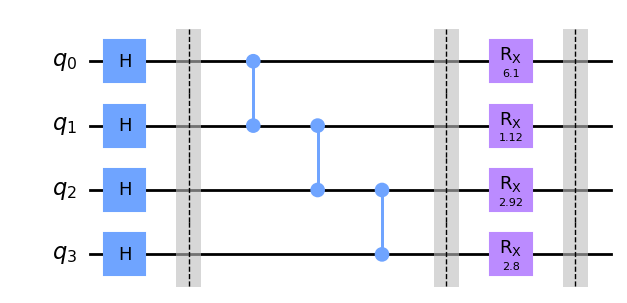

In [11]:
circuitA = sampleCircuitA(qubits=4)
circuitA.draw(output='mpl')

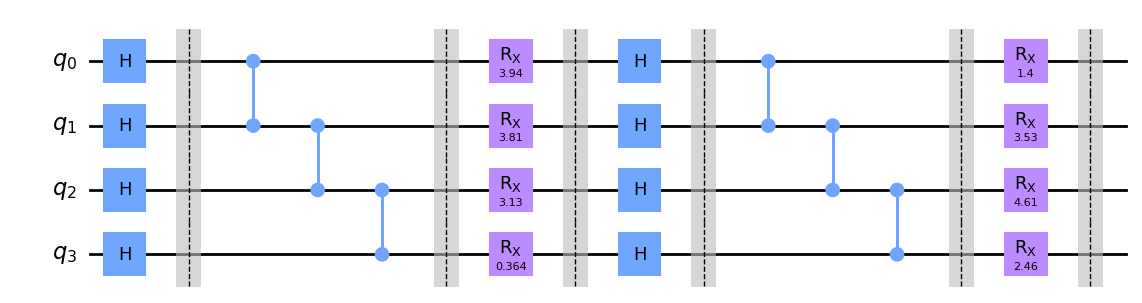

In [13]:
circuitA = sampleCircuitA(layer=2)
circuitA.draw(output='mpl')

## 1.2 Circuit B

In [18]:
def sampleCircuitB(layer=1, qubits=4):
    circuit = QuantumCircuit(qubits)
    
    for i in range(layer):
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        circuit.cx(0, 1)
        circuit.barrier()
        
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.cx(1, 2)
        circuit.barrier()
        
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
        circuit.cx(2, 3)
        circuit.barrier()
    
    return circuit

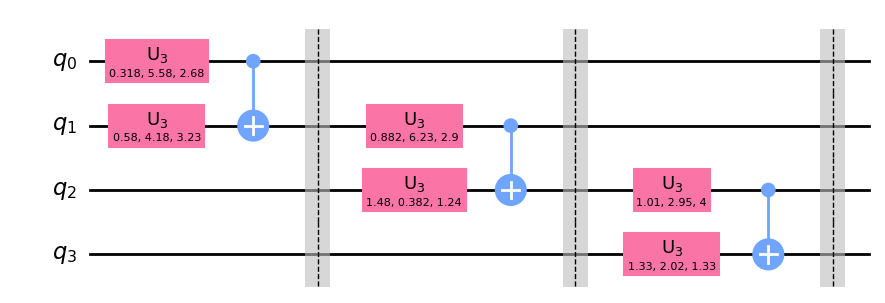

In [19]:
circuitB1 = sampleCircuitB(qubits=4)
circuitB1.draw(output='mpl')

## 1.3 Circuit C

In [28]:
def sampleCircuitC(layer=1, qubits=4, encode=False):
    circuit = QuantumCircuit(qubits)
    
    for i in range(qubits):
        circuit.rx(np.random.uniform(0, 2 * np.pi), i)
        circuit.rz(np.random.uniform(0, 2 * np.pi), i)
    circuit.barrier()
    
    for i in range(layer):
        for j in range(qubits - 1):
            circuit.cx(j, j + 1)
        circuit.barrier()
        for i in range(qubits):
            circuit.rx(np.random.uniform(0, 2 * np.pi), i)
            circuit.rz(np.random.uniform(0, 2 * np.pi), i)
        circuit.barrier()

    return circuit

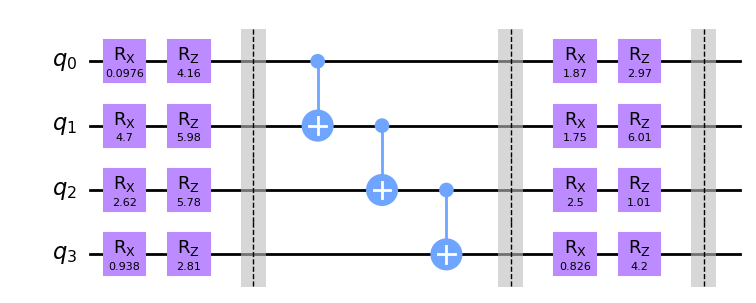

In [29]:
circuitC = sampleCircuitC(qubits=4)
circuitC.draw(output='mpl')

# 2. Measure Expressibililty

## 2.1 Tool Functions

In [30]:
def P_haar(N, F):
    if F == 1:
        return 0
    return (N - 1) * ((1 - F) ** (N - 2))

In [31]:
def KL(P, Q):
    epsilon = 1e-8
    kl_divergence = 0.0
    
    for p, q in zip(P, Q):
        kl_divergence += p * np.log( (p + epsilon) / (q + epsilon) )
    
    return abs(kl_divergence)

## 2.2 Measure algorithm

In [45]:
def expressibility(qubits, sampler, *, bins=100, epoch=3000, layer=1, encode=False, return_detail=False):
    unit = 1 / bins
    limits = []
    probabilities = np.array([0] * bins)
    for i in range(1, bins + 1):
        limits.append(unit * i)

    for i in range(epoch):
        circuit_1 = sampler(layer=layer, qubits=qubits)
        circuit_2 = sampler(layer=layer, qubits=qubits)
        f = state_fidelity(
            getStatevector(circuit_1),
            getStatevector(circuit_2)
        )

        for j in range(bins):
            if f <= limits[j]:
                probabilities[j] += 1
                break

    pHaar_vqc = [ P_haar(2 ** qubits, f - (unit/2)) / bins for f in limits]
    probabilities = [ p / epoch for p in probabilities ]
    
    if return_detail:
        return pHaar_vqc, probabilities
    else:
        return KL(probabilities, pHaar_vqc)

## 2.3 Experiments

In [56]:
labels = [
    'Circuit A', 'Circuit B',
    'Circuit C'
]

samplers = [
#     sampleCircuitA,
    sampleCircuitB,
    sampleCircuitC,
]

In [57]:
q = 4
for layer in range(1, 4):
    print(f'qubtis: {q}')
    print('-' * 25)

    for (label, sampler) in zip(labels, samplers):
        print(f'{label}(layer={layer}): {expressibility(q, sampler, layer=layer, epoch=3000)}')
    print()

qubtis: 4
-------------------------
Circuit A(layer=1): 0.2007898847047706
Circuit B(layer=1): 0.026187504066791316

qubtis: 4
-------------------------
Circuit A(layer=2): 0.014148057088842538
Circuit B(layer=2): 0.00847501793651174

qubtis: 4
-------------------------
Circuit A(layer=3): 0.010270694698746197
Circuit B(layer=3): 0.007165197936448614



In [43]:
q = 4
for layer in range(3, 4):
    print(f'qubtis: {q}')
    print('-' * 25)

    for (label, sampler) in zip(labels, samplers):
        print(f'{label}(layer={layer}): {expressibility(q, sampler, layer=layer, epoch=3000)}')
    print()

qubtis: 4
-------------------------
Circuit A(layer=3): 1.4466601041642226
Circuit B(layer=3): 2.017343849187396
Circuit C(layer=3): 2.167155710733102



In [44]:
q = 4
for layer in range(4, 5):
    print(f'qubtis: {q}')
    print('-' * 25)

    for (label, sampler) in zip(labels, samplers):
        print(f'{label}(layer={layer}): {expressibility(q, sampler, layer=layer, epoch=3000)}')
    print()

qubtis: 4
-------------------------
Circuit A(layer=4): 1.9788096091111522
Circuit B(layer=4): 1.9769717193668057
Circuit C(layer=4): 2.030780640611926



In [114]:
# qubtis: 3
# -------------------------
# Circuit A(layer=1): 0.690232071447602
# Circuit B1(layer=1): -1.265305673348496
# Circuit B2(layer=1): 1.4222476112291147
# Circuit B3(layer=1): 1.904341407658621    2
# Circuit C(layer=1): 1.7683114656867647
# Circuit D(layer=1): 2.0149688608120275
# Circuit E(layer=1): 1.350659808290902
# Circuit F(layer=1): 0.1997617469436713
# Circuit G(layer=1): 1.4274790726044533

# qubtis: 4
# -------------------------
# Circuit A(layer=1): 0.49087234914376765
# Circuit B1(layer=1): -1.2653056759271715
# Circuit B2(layer=1): 1.3293845544181009
# Circuit B3(layer=1): 1.427799700443171    3
# Circuit C(layer=1): 1.9108353678384467
# Circuit D(layer=1): 2.163546140578867
# Circuit E(layer=1): 1.0610004295081807
# Circuit F(layer=1): 0.1365762295335004
# Circuit G(layer=1): 1.164537157460661

# qubtis: 5
# -------------------------
# Circuit A(layer=1): 0.450750335070193
# Circuit B1(layer=1): -1.2653056759271715
# Circuit B2(layer=1): 1.403125962257167   3
# Circuit B3(layer=1): 1.1643464389669391
# Circuit C(layer=1): 1.4207855670068568
# Circuit D(layer=1): 2.17955242807267
# Circuit E(layer=1): 0.8390156196711931
# Circuit F(layer=1): 0.16455991922583854
# Circuit G(layer=1): 0.8926204249076167

In [115]:
# qubtis: 3
# -------------------------
# Circuit A(layer=2): 1.2437275589487584
# Circuit B1(layer=2): -1.265305673348496
# Circuit B2(layer=2): 1.8449716890827017
# Circuit B3(layer=2): 2.120318237126669    3
# Circuit C(layer=2): 2.1467584466892795
# Circuit D(layer=2): 2.1540988071580203
# Circuit E(layer=2): 1.8171977407701971
# Circuit F(layer=2): 0.6428813156248389
# Circuit G(layer=2): 2.106001529821252

# qubtis: 4
# -------------------------
# Circuit A(layer=2): 2.0328593469798624
# Circuit B1(layer=2): -1.2653056759271715
# Circuit B2(layer=2): 2.061067632775542    3
# Circuit B3(layer=2): 1.9298063145593727
# Circuit C(layer=2): 2.19335633438496
# Circuit D(layer=2): 2.100748123011952
# Circuit E(layer=2): 1.5483869951283054
# Circuit F(layer=2): 0.527171633219818
# Circuit G(layer=2): 1.955687735542224

# qubtis: 5
# -------------------------
# Circuit A(layer=2): 1.7240495231557238
# Circuit B1(layer=2): -1.2653056759271715
# Circuit B2(layer=2): 2.0817395350789307   3
# Circuit B3(layer=2): 1.618337485917731
# Circuit C(layer=2): 2.024931456036019
# Circuit D(layer=2): 2.145100079665334   
# Circuit E(layer=2): 1.2429169134096916
# Circuit F(layer=2): 0.5141969659633326
# Circuit G(layer=2): 1.6545263986911545

In [116]:
# qubtis: 3
# -------------------------
# Circuit A(layer=3): 1.976071296024617
# Circuit B1(layer=3): -1.265305673348496
# Circuit B2(layer=3): 2.0739591205387753   4
# Circuit B3(layer=3): 2.089450137526081
# Circuit C(layer=3): 2.0727351579175153
# Circuit D(layer=3): 2.1518617150903183
# Circuit E(layer=3): 2.0980251918089707
# Circuit F(layer=3): 0.7161497707825539
# Circuit G(layer=3): 2.141244102123575

# qubtis: 4
# -------------------------
# Circuit A(layer=3): 2.429236134947001
# Circuit B1(layer=3): -1.2653056759271715
# Circuit B2(layer=3): 2.2506126337158263    3
# Circuit B3(layer=3): 2.162263235746228
# Circuit C(layer=3): 2.1686406127190474
# Circuit D(layer=3): 2.2616041812187406
# Circuit E(layer=3): 1.919440134100542
# Circuit F(layer=3): 0.7345825309404356
# Circuit G(layer=3): 2.0929312935155613

# qubtis: 5
# -------------------------
# Circuit A(layer=3): 2.0159903512211206
# Circuit B1(layer=3): -1.2653056759271715
# Circuit B2(layer=3): 2.1881279776952502    2
# Circuit B3(layer=3): 2.0164052744686973
# Circuit C(layer=3): 2.1761956111206353
# Circuit D(layer=3): 2.1884222525289316
# Circuit E(layer=3): 1.4812706973990588
# Circuit F(layer=3): 0.704153587194987
# Circuit G(layer=3): 2.015932985724776

In [117]:
# qubtis: 3
# -------------------------
# Circuit A(layer=4): 2.106376586028353
# Circuit B1(layer=4): -1.265305673348496
# Circuit B2(layer=4): 2.0107531017242657
# Circuit B3(layer=4): 2.2157210687870204   1
# Circuit C(layer=4): 2.1459932806688364
# Circuit D(layer=4): 2.159406762547182
# Circuit E(layer=4): 2.011958136914084
# Circuit F(layer=4): 0.7863711935285442
# Circuit G(layer=4): 2.0969111639345397

# qubtis: 4
# -------------------------
# Circuit A(layer=4): 2.2941342823533204       
# Circuit B1(layer=4): -1.2653056759271715
# Circuit B2(layer=4): 2.190118508691123
# Circuit B3(layer=4): 2.195487987471052     5
# Circuit C(layer=4): 2.2397970659388546
# Circuit D(layer=4): 2.2005641856450397
# Circuit E(layer=4): 2.0406704179088595
# Circuit F(layer=4): 0.8166804259748363
# Circuit G(layer=4): 2.2195363311642327

# qubtis: 5
# -------------------------
# Circuit A(layer=4): 2.1612896300162645
# Circuit B1(layer=4): -1.2653056759271715
# Circuit B2(layer=4): 2.073179215881938
# Circuit B3(layer=4): 2.0860215084022244     5
# Circuit C(layer=4): 2.1816234923052176
# Circuit D(layer=4): 2.1693901732228658
# Circuit E(layer=4): 1.909873030364573
# Circuit F(layer=4): 0.8989564027391959
# Circuit G(layer=4): 2.2323956272172087

### - encoded case

In [138]:
for layer in range(1, 5):
    for q in range(3, 6):
        print(f'qubtis: {q}')
        print('-' * 25)
        
        for (label, sampler) in zip(labels, samplers):
            arr = []
            for i in range(10):
                expr = expressibility(q, sampler, layer=layer, epoch=2000, encode=True)
                arr.append(expr)
            print(f'{label}(layer={layer}): {np.mean(arr)}')
        print()

qubtis: 3
-------------------------
Circuit A(layer=1): 1.084067705870187
Circuit B1(layer=1): 0.648461140764993
Circuit B2(layer=1): 1.6513257921445152
Circuit B3(layer=1): 1.6962808791311699
Circuit C(layer=1): 1.513079067649706
Circuit D(layer=1): 1.713602955579977
Circuit E(layer=1): 1.356002715888513
Circuit F(layer=1): 0.188904327254051
Circuit G(layer=1): 1.5549241677881738

qubtis: 4
-------------------------
Circuit A(layer=1): 1.593804850503663
Circuit B1(layer=1): 0.48930534446120477
Circuit B2(layer=1): 1.6401810016757565
Circuit B3(layer=1): 1.6482774166044372
Circuit C(layer=1): 1.6591738974221073
Circuit D(layer=1): 1.950020025668715
Circuit E(layer=1): 1.1387392869774862
Circuit F(layer=1): 0.13905340774018468
Circuit G(layer=1): 1.305201713248581

qubtis: 5
-------------------------
Circuit A(layer=1): 1.3789330295160718
Circuit B1(layer=1): 0.4235156770067488
Circuit B2(layer=1): 1.4479122842081449
Circuit B3(layer=1): 1.4247781380406521
Circuit C(layer=1): 1.34449616

In [139]:
# qubtis: 3
# -------------------------
# Circuit A(layer=1): 1.084067705870187
# Circuit B1(layer=1): 0.648461140764993
# Circuit B2(layer=1): 1.6513257921445152
# Circuit B3(layer=1): 1.6962808791311699
# Circuit C(layer=1): 1.513079067649706
# Circuit D(layer=1): 1.713602955579977
# Circuit E(layer=1): 1.356002715888513
# Circuit F(layer=1): 0.188904327254051
# Circuit G(layer=1): 1.5549241677881738

# qubtis: 4
# -------------------------
# Circuit A(layer=1): 1.593804850503663
# Circuit B1(layer=1): 0.48930534446120477
# Circuit B2(layer=1): 1.6401810016757565
# Circuit B3(layer=1): 1.6482774166044372
# Circuit C(layer=1): 1.6591738974221073
# Circuit D(layer=1): 1.950020025668715
# Circuit E(layer=1): 1.1387392869774862
# Circuit F(layer=1): 0.13905340774018468
# Circuit G(layer=1): 1.305201713248581

# qubtis: 5
# -------------------------
# Circuit A(layer=1): 1.3789330295160718
# Circuit B1(layer=1): 0.4235156770067488
# Circuit B2(layer=1): 1.4479122842081449
# Circuit B3(layer=1): 1.4247781380406521
# Circuit C(layer=1): 1.344496162760184
# Circuit D(layer=1): 2.030349220802343
# Circuit E(layer=1): 0.8934323553989373
# Circuit F(layer=1): 0.1786636933176564
# Circuit G(layer=1): 1.0785274840090644

In [140]:
# qubtis: 3
# -------------------------
# Circuit A(layer=2): 1.548986288220274
# Circuit B1(layer=2): 0.6567265850060193
# Circuit B2(layer=2): 1.672723579656283
# Circuit B3(layer=2): 1.7266229500031973
# Circuit C(layer=2): 1.7137937940786094
# Circuit D(layer=2): 1.743190477408973
# Circuit E(layer=2): 1.630289590873024
# Circuit F(layer=2): 0.6060411983335461
# Circuit G(layer=2): 1.7067663787458103

# qubtis: 4
# -------------------------
# Circuit A(layer=2): 1.892265150219703
# Circuit B1(layer=2): 0.484309898387891
# Circuit B2(layer=2): 1.866869430264194
# Circuit B3(layer=2): 1.8500053187463927
# Circuit C(layer=2): 1.8481202905421497
# Circuit D(layer=2): 1.93466325934907
# Circuit E(layer=2): 1.4886526206434947
# Circuit F(layer=2): 0.5165256110447153
# Circuit G(layer=2): 1.7975620324860213

# qubtis: 5
# -------------------------
# Circuit A(layer=2): 1.8672817452378276
# Circuit B1(layer=2): 0.4274001712293833
# Circuit B2(layer=2): 1.9444674156028352
# Circuit B3(layer=2): 1.676980628487027
# Circuit C(layer=2): 1.872063831759012
# Circuit D(layer=2): 1.9663635235065737
# Circuit E(layer=2): 1.2737612376860512
# Circuit F(layer=2): 0.47516717154349913
# Circuit G(layer=2): 1.6860714713049787

In [141]:
# qubtis: 3
# -------------------------
# Circuit A(layer=3): 1.710893988794949
# Circuit B1(layer=3): 0.6396028968958499
# Circuit B2(layer=3): 1.7333320732268878
# Circuit B3(layer=3): 1.7835342052222725
# Circuit C(layer=3): 1.7663293534424613
# Circuit D(layer=3): 1.7414604925448782
# Circuit E(layer=3): 1.6799610653724883
# Circuit F(layer=3): 0.6883159600545941
# Circuit G(layer=3): 1.710392171821552

# qubtis: 4
# -------------------------
# Circuit A(layer=3): 1.9452303791879184
# Circuit B1(layer=3): 0.46429105688884975
# Circuit B2(layer=3): 1.901664822961657
# Circuit B3(layer=3): 1.8744175021895242
# Circuit C(layer=3): 1.917429030944612
# Circuit D(layer=3): 1.9136527602057114
# Circuit E(layer=3): 1.6967172768105847
# Circuit F(layer=3): 0.696620153723184
# Circuit G(layer=3): 1.9129624272191983

# qubtis: 5
# -------------------------
# Circuit A(layer=3): 2.0084307507203496
# Circuit B1(layer=3): 0.43309412021664545
# Circuit B2(layer=3): 1.9378274198430887
# Circuit B3(layer=3): 1.915255898818792
# Circuit C(layer=3): 2.0251430572147937
# Circuit D(layer=3): 1.983818915693049
# Circuit E(layer=3): 1.4954022404465672
# Circuit F(layer=3): 0.6999260997244166
# Circuit G(layer=3): 1.88974967426299

In [142]:
# qubtis: 3
# -------------------------
# Circuit A(layer=4): 1.7153053977573745
# Circuit B1(layer=4): 0.6590794510947597
# Circuit B2(layer=4): 1.7412799120058913
# Circuit B3(layer=4): 1.7796258066380752
# Circuit C(layer=4): 1.725211326316525
# Circuit D(layer=4): 1.7444250190634634
# Circuit E(layer=4): 1.709686524680991
# Circuit F(layer=4): 0.7488840577013784
# Circuit G(layer=4): 1.7553336307115999

# qubtis: 4
# -------------------------
# Circuit A(layer=4): 1.8964249646945135
# Circuit B1(layer=4): 0.4810593556772277
# Circuit B2(layer=4): 1.8961780980558003
# Circuit B3(layer=4): 1.899303619894526
# Circuit C(layer=4): 1.9389948860969213
# Circuit D(layer=4): 1.9366606029322675
# Circuit E(layer=4): 1.8102758213900525
# Circuit F(layer=4): 0.7966561754828172
# Circuit G(layer=4): 1.9348365663959377

# qubtis: 5
# -------------------------
# Circuit A(layer=4): 1.9757044591280526
# Circuit B1(layer=4): 0.4306026817001835
# Circuit B2(layer=4): 1.9565557910364109
# Circuit B3(layer=4): 1.9895915889086162
# Circuit C(layer=4): 1.9798713259408398
# Circuit D(layer=4): 1.9840278022188058
# Circuit E(layer=4): 1.7002733254796265
# Circuit F(layer=4): 0.8472042168243791
# Circuit G(layer=4): 1.9890088093248501


In [202]:
for layer in range(1, 2):
    for q in range(3, 4):
        print(f'qubtis: {q}')
        print('-' * 25)
        
        for (label, sampler) in zip(labels, samplers):
            print(f'{label}(layer={layer}): {expressibility(q, sampler, layer=layer, epoch=10000, encode=True)}')
        print()

qubtis: 3
-------------------------
Circuit A(layer=1): 1.18899735487227
Circuit B1(layer=1): 0.7039137172964489
Circuit B2(layer=1): 2.174665012040821
Circuit B3(layer=1): 2.286774029134111
Circuit C(layer=1): 1.7987715370194717
Circuit D(layer=1): 2.2867851341320815
Circuit E(layer=1): 1.545804478468228
Circuit G(layer=1): 1.9053018737761138



In [218]:
for layer in range(1, 2):
    for q in range(4, 5):
        print(f'qubtis: {q}')
        print('-' * 25)
        
        for (label, sampler) in zip(labels, samplers):
            print(f'{label}(layer={layer}): {expressibility(q, sampler, layer=layer, epoch=10000, encode=True)}')
        print()

qubtis: 4
-------------------------
Circuit A(layer=1): 1.7241053422778319
Circuit B1(layer=1): 0.5030400508547164
Circuit B2(layer=1): 1.880754444848152
Circuit B3(layer=1): 1.9320490977832985
Circuit C(layer=1): 1.836796292342725
Circuit D(layer=1): 2.418547941702126
Circuit E(layer=1): 1.2194783693754583
Circuit G(layer=1): 1.3898184268603708



In [217]:
for layer in range(1, 2):
    for q in range(5, 6):
        print(f'qubtis: {q}')
        print('-' * 25)
        
        for (label, sampler) in zip(labels, samplers):
            print(f'{label}(layer={layer}): {expressibility(q, sampler, layer=layer, epoch=4000, encode=True)}')
        print()

qubtis: 5
-------------------------
Circuit A(layer=1): 1.3756215230718896
Circuit B1(layer=1): 0.45565722286644084
Circuit B2(layer=1): 1.3918797102735134
Circuit B3(layer=1): 1.4790510985244967
Circuit C(layer=1): 1.4339755208697902
Circuit D(layer=1): 2.1228091988257547
Circuit E(layer=1): 0.941971138349508
Circuit G(layer=1): 1.1517231557969954



In [251]:
expressibility(4, sampleCircuitD, encode=True, epoch=3000)

2.12533287866682

In [249]:
expressibility(5, sampleCircuitB3, encode=True, epoch=20000)

1.5185501878450556

# 3. Encoding

In [207]:
def sampleEncodeA(layer=1, encode=False, qubits=4):
    circuit = QuantumCircuit(qubits)
    
    for i in range(qubits):
        circuit.rx(np.random.uniform(0, 2) * np.pi, i)
    
    return circuit

In [208]:
def sampleEncodeB(layer=1, encode=False, qubits=4):
    circuit = QuantumCircuit(qubits)
    
    for i in range(qubits):
        circuit.h(i)
        circuit.ry(np.random.uniform(0, 2) * np.pi, i)
    
    return circuit

In [209]:
def sampleEncodeC(layer=1, encode=False, qubits=4):
    circuit = QuantumCircuit(qubits)
    
    for i in range(qubits):
        circuit.h(i)
        circuit.rz(np.random.uniform(0, 2) * np.pi, i)
    
    return circuit

In [221]:
labels = [
    'Encode A', 'Encode B', 'Encode C'
]

samplers = [
    sampleEncodeA,
    sampleEncodeB,
    sampleEncodeC
]

In [211]:
for q in range(1, 6):
    print(f'qubtis: {q}')
    print('-' * 25)

    for (label, sampler) in zip(labels, samplers):
        arr = []
        for i in range(1):
            expr = expressibility(q, sampler, epoch=10000)
            arr.append(expr)
        print(f'{label}: {np.mean(arr)}')
    print()

qubtis: 1
-------------------------
Encode A: 0.6555593752219606
Encode B: 0.6746632900445776
Encode C: 0.6592284740813538

qubtis: 2
-------------------------
Encode A: 0.3679621498816045
Encode B: 0.35213162050082186
Encode C: 0.3670825165041791

qubtis: 3
-------------------------
Encode A: 0.19194598445882807
Encode B: 0.2141823239967739
Encode C: 0.21548088809062257

qubtis: 4
-------------------------
Encode A: 0.17063982480961187
Encode B: 0.16248219685172208
Encode C: 0.16099038430115692

qubtis: 5
-------------------------
Encode A: 0.1809459313257383
Encode B: 0.18240566261469185
Encode C: 0.1618571288367288



In [192]:
arr = []
for i in range(2):
    arr.append(expressibility(4, sampleEncodeB))
print(np.mean(arr))

0.1388884241760782
